In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
! pip install grad-cam==1.4.8

In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.models.segmentation.fcn import fcn_resnet50
from osgeo import gdal
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [44]:
txt_path = '/content/drive/MyDrive/RS/HAND/test.txt'
S1_path = '/content/drive/MyDrive/RS/HAND/S1_split/'
S2_path = '/content/drive/MyDrive/RS/HAND/S2_split/'
with open(txt_path,'r') as f:
    imagelist = f.readlines()
fname = imagelist[18][:-1]
img1_path = os.path.join(S1_path,fname)
img2_path = os.path.join(S2_path,fname)
img1 = gdal.Open(img1_path)
img2 = gdal.Open(img2_path)

In [45]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [46]:
class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model):
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)["out"]

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()

    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()

In [47]:
def cam_by_model(model,input_tensor):
  # 模型封装
  model.eval()
  # model = SegmentationModelOutputWrapper(model)
  output = model(input_tensor)
  # cam 前处理
  normalized_mask = torch.nn.functional.softmax(output, dim=1)
  sem_classes = ['background', 'water']
  sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}
  water_category = sem_class_to_idx['water']
  water_mask = normalized_mask[0,:,:,:].argmax(dim=0).detach().cpu().numpy()
  water_mask_unit8 = 255 * np.uint8(water_mask==water_category)
  water_mask_float = np.float32(water_mask==water_category)
  # cam操作1
  target_layers = model.conv1.block
  targets = [SemanticSegmentationTarget(water_category, water_mask_float)]
  with GradCAM(model=model,
        target_layers=target_layers,
        use_cuda=torch.cuda.is_available()) as cam:
      grayscale_cam1 = cam(input_tensor=input_tensor,targets=targets)[0,:]
  # cam操作2
  target_layers = model.conv2.block
  targets = [SemanticSegmentationTarget(water_category, water_mask_float)]
  with GradCAM(model=model,
        target_layers=target_layers,
        use_cuda=torch.cuda.is_available()) as cam:
      grayscale_cam2 = cam(input_tensor=input_tensor,targets=targets)[0,:]
  # cam操作3
  target_layers = model.conv7.block
  targets = [SemanticSegmentationTarget(water_category, water_mask_float)]
  with GradCAM(model=model,
        target_layers=target_layers,
        use_cuda=torch.cuda.is_available()) as cam:
      grayscale_cam3 = cam(input_tensor=input_tensor,targets=targets)[0,:]
  # cam操作4
  target_layers = model.conv8.block
  targets = [SemanticSegmentationTarget(water_category, water_mask_float)]
  with GradCAM(model=model,
        target_layers=target_layers,
        use_cuda=torch.cuda.is_available()) as cam:
      grayscale_cam4 = cam(input_tensor=input_tensor,targets=targets)[0,:]
  return grayscale_cam1, grayscale_cam2, grayscale_cam3, grayscale_cam4

In [48]:
# 定义块
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1,
                      stride=1, padding_mode='reflect', bias=False),

            nn.BatchNorm2d(out_channels),
            # nn.InstanceNorm2d(out_channels),  # nnUNet

            nn.ReLU(inplace=True),
            # nn.LeakyReLU(),  # nnUNet

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1,
                      stride=1, padding_mode='reflect', bias=False),

            nn.BatchNorm2d(out_channels),
            # nn.InstanceNorm2d(out_channels),  # nnUNet

            nn.ReLU(inplace=True)
            # nn.LeakyReLU()  # nnUNet
        )

    def forward(self, x):
        return self.block(x)


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSample, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.block(x)


In [49]:
# 定义UNet模型
class UNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=2):
        super().__init__()
        self.conv1 = DoubleConv(in_channels, 64)
        self.down1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = DoubleConv(64, 128)
        self.down2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128, 256)
        self.down3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = DoubleConv(256, 512)
        self.down4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_mid = DoubleConv(512, 1024)

        self.up1 = UpSample(1024, 512)
        self.conv5 = DoubleConv(1024,512)
        self.up2 = UpSample(512, 256)
        self.conv6 = DoubleConv(512,256)
        self.up3 = UpSample(256, 128)
        self.conv7 = DoubleConv(256,128)
        self.up4 = UpSample(128, 64)
        self.conv8 = DoubleConv(128,64)

        self.out_channel = nn.Conv2d(64, out_channels, kernel_size=1, stride=1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        down1 = self.down1(conv1)
        conv2 = self.conv2(down1)
        down2 = self.down2(conv2)
        conv3 = self.conv3(down2)
        down3 = self.down3(conv3)
        conv4 = self.conv4(down3)
        down4 = self.down4(conv4)

        conv_mid = self.conv_mid(down4)

        up1 = self.up1(conv_mid)
        cat1 = torch.cat([up1, conv4], dim=1)
        down5  = self.conv5(cat1)

        up2 = self.up2(down5)
        cat2 = torch.cat([up2, conv3], dim=1)
        down6  = self.conv6(cat2)

        up3 = self.up3(down6)
        cat3 = torch.cat([up3, conv2], dim=1)
        down7  = self.conv7(cat3)

        up4 = self.up4(down7)
        cat4 = torch.cat([up4, conv1], dim=1)
        down8  = self.conv8(cat4)

        out_channel = self.out_channel(down8)

        return out_channel


In [50]:
# 加载模型
S1_model = UNet(in_channels=2)
S1_model.load_state_dict(torch.load('/content/drive/MyDrive/RS/HAND/UNet_S1_state_dict.pth'))
# 前处理
S1_input = img1.ReadAsArray()[0:2]  # 前两个波段
S1_input = np.nan_to_num(S1_input) # 去除空值
S1_input = (S1_input + 50) / 51 # 归一化
S1_input = np.transpose(S1_input,(1,2,0)) # 调整维度
input_tensor = transform(S1_input).unsqueeze(0)
S1grayscale_cam1, S1grayscale_cam2, S1grayscale_cam3, S1grayscale_cam4 = cam_by_model(S1_model,input_tensor)

In [51]:
# 加载模型
S1D_model = UNet(in_channels=3)
S1D_model.load_state_dict(torch.load('/content/drive/MyDrive/RS/HAND/UNet_S1D_state_dict.pth'))
# 前处理
S1D_input = img1.ReadAsArray()[0:3]  # 前两个波段
S1D_input = np.transpose(S1D_input,(1,2,0)) # 调整维度
S1D_input = np.nan_to_num(S1D_input) # 去除空值
S1D_input[0:2] = (S1D_input[0:2] + 50) / 51 # 归一化
S1D_input[3] = (S1D_input[3] - np.min(S1D_input[3])) / (np.max(S1D_input[3]) - np.min(S1D_input[3]))
S1D_input[3][np.isnan(S1D_input[3])] = 0
S1D_input[3][np.isinf(S1D_input[3])] = 0
input_tensor = transform(S1D_input).unsqueeze(0)
S1Dgrayscale_cam1, S1Dgrayscale_cam2, S1Dgrayscale_cam3, S1Dgrayscale_cam4 = cam_by_model(S1D_model,input_tensor)

In [52]:
# 加载模型
S2_model = UNet(in_channels=3)
S2_model.load_state_dict(torch.load('/content/drive/MyDrive/RS/HAND/UNet_S2_state_dict.pth'))
# 前处理
S2_input = np.zeros([3,512,512])
S2_input[0] = img2.ReadAsArray()[2,:,:]
S2_input[1] = img2.ReadAsArray()[7,:,:]
S2_input[2] = img2.ReadAsArray()[10,:,:]
S2_input = np.transpose(S2_input,(1,2,0))
S2_input = np.nan_to_num(S2_input)
S2_input = S2_input / 5000
input_tensor = transform(S2_input).unsqueeze(0).float()
S2grayscale_cam1, S2grayscale_cam2, S2grayscale_cam3, S2grayscale_cam4 = cam_by_model(S2_model,input_tensor)

In [53]:
# 加载模型
S2D_model = UNet(in_channels=4)
S2D_model.load_state_dict(torch.load('/content/drive/MyDrive/RS/HAND/UNet_S2D_state_dict.pth'))
# 前处理
S2D_input = np.zeros([4,512,512])
S2D_input[0] = img2.ReadAsArray()[2,:,:]
S2D_input[1] = img2.ReadAsArray()[7,:,:]
S2D_input[2] = img2.ReadAsArray()[10,:,:]
S2D_input[3] = img1.ReadAsArray()[2,:,:]
S2D_input = np.nan_to_num(S2D_input)
S2D_input[0:3] = S2D_input[0:3] / 5000
S2D_input[3] = (S2D_input[3] - np.min(S2D_input[3])) / (np.max(S2D_input[3]) - np.min(S2D_input[3]))
S2D_input[3][np.isnan(S2D_input[3])] = 0
S2D_input[3][np.isinf(S2D_input[3])] = 0
S2D_input = np.transpose(S2D_input,(1,2,0))
input_tensor = transform(S2D_input).unsqueeze(0).float()
S2Dgrayscale_cam1, S2Dgrayscale_cam2, S2Dgrayscale_cam3, S2Dgrayscale_cam4 = cam_by_model(S2D_model,input_tensor)

In [54]:
# 加载模型
S1S2_model = UNet(in_channels=5)
S1S2_model.load_state_dict(torch.load('/content/drive/MyDrive/RS/HAND/UNet_S1S2_state_dict.pth'))
# 前处理
S1S2_input = np.zeros([5,512,512])
S1S2_input[0:2] = img1.ReadAsArray()[0:2]
S1S2_input[2] = img2.ReadAsArray()[2]
S1S2_input[3] = img2.ReadAsArray()[7]
S1S2_input[4] = img2.ReadAsArray()[10]
S1S2_input = np.nan_to_num(S1S2_input)
S1S2_input[0:2] = (S1S2_input[0:2] + 50) / 51
S1S2_input[2:] = S1S2_input[2:] / 5000
S1S2_input = np.transpose(S1S2_input,(1,2,0))
input_tensor = transform(S1S2_input).unsqueeze(0).float()
S1S2grayscale_cam1, S1S2grayscale_cam2, S1S2grayscale_cam3, S1S2grayscale_cam4 = cam_by_model(S1S2_model,input_tensor)

In [55]:
# 加载模型
S1S2D_model = UNet(in_channels=6)
S1S2D_model.load_state_dict(torch.load('/content/drive/MyDrive/RS/HAND/UNet_S1S2D_state_dict.pth'))
# 前处理
S1S2D_input = np.zeros([6,512,512])
S1S2D_input[0:2] = img1.ReadAsArray()[0:2]
S1S2D_input[2] = img2.ReadAsArray()[2]
S1S2D_input[3] = img2.ReadAsArray()[7]
S1S2D_input[4] = img2.ReadAsArray()[10]
S1S2D_input[5] = img1.ReadAsArray()[2]
S1S2D_input = np.nan_to_num(S1S2D_input)
S1S2D_input[0:2] = (S1S2D_input[0:2] + 50) / 51
S1S2D_input[2:5] = S1S2D_input[2:5] / 5000
S1S2D_input[5] = (S1S2D_input[5] - np.min(S1S2D_input[5])) / (np.max(S1S2D_input[5]) - np.min(S1S2D_input[5]))
S1S2D_input = np.transpose(S1S2D_input,(1,2,0))
input_tensor = transform(S1S2D_input).unsqueeze(0).float()
S1S2Dgrayscale_cam1, S1S2Dgrayscale_cam2, S1S2Dgrayscale_cam3, S1S2Dgrayscale_cam4 = cam_by_model(S1S2D_model,input_tensor)

Exception ignored in: <function BaseCAM.__del__ at 0x7cd987d1f490>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pytorch_grad_cam/base_cam.py", line 192, in __del__
    self.activations_and_grads.release()
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


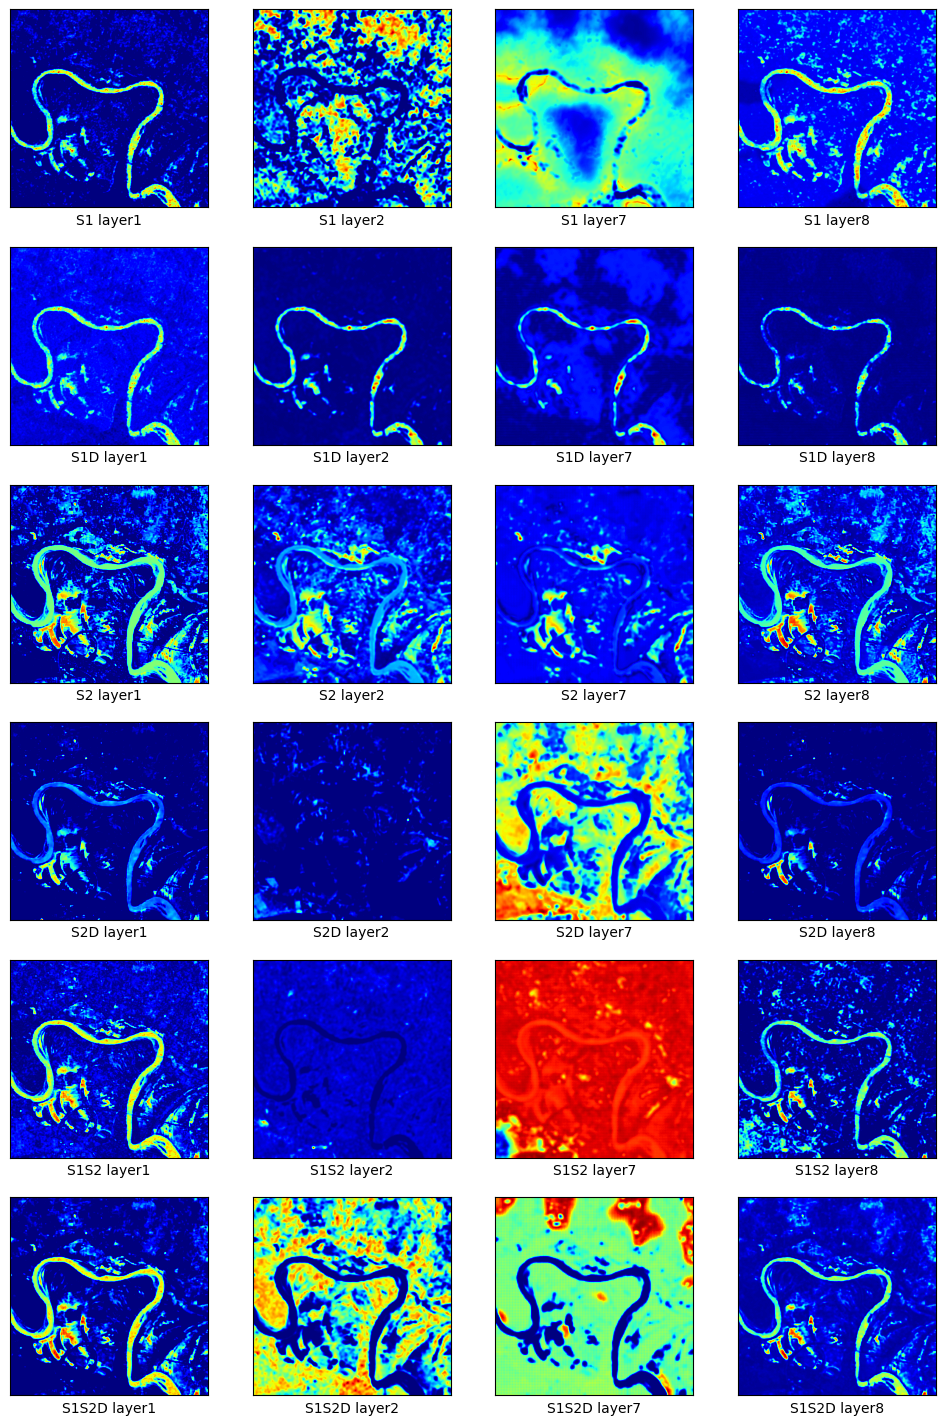

In [56]:
fig,ax = plt.subplots(nrows=6,ncols=4)
fig.set_size_inches(12,18) # 调整大小
for i in range(6):
  for j in range(4):
    ax[i,j].set_xticks([])  # 删除坐标轴
    ax[i,j].set_yticks([])
# S1
ax[0,0].imshow(S1grayscale_cam1,cmap='jet')
ax[0,0].set_xlabel('S1 layer1')

ax[0,1].imshow(S1grayscale_cam2,cmap='jet')
ax[0,1].set_xlabel('S1 layer2')

ax[0,2].imshow(S1grayscale_cam3,cmap='jet')
ax[0,2].set_xlabel('S1 layer7')

ax[0,3].imshow(S1grayscale_cam4,cmap='jet')
ax[0,3].set_xlabel('S1 layer8')

# S1D
ax[1,0].imshow(S1Dgrayscale_cam1,cmap='jet')
ax[1,0].set_xlabel('S1D layer1')

ax[1,1].imshow(S1Dgrayscale_cam2,cmap='jet')
ax[1,1].set_xlabel('S1D layer2')

ax[1,2].imshow(S1Dgrayscale_cam3,cmap='jet')
ax[1,2].set_xlabel('S1D layer7')

ax[1,3].imshow(S1Dgrayscale_cam4,cmap='jet')
ax[1,3].set_xlabel('S1D layer8')

# S2
ax[2,0].imshow(S2grayscale_cam1,cmap='jet')
ax[2,0].set_xlabel('S2 layer1')

ax[2,1].imshow(S2grayscale_cam2,cmap='jet')
ax[2,1].set_xlabel('S2 layer2')

ax[2,2].imshow(S2grayscale_cam3,cmap='jet')
ax[2,2].set_xlabel('S2 layer7')

ax[2,3].imshow(S2grayscale_cam4,cmap='jet')
ax[2,3].set_xlabel('S2 layer8')

# S2D
ax[3,0].imshow(S2Dgrayscale_cam1,cmap='jet')
ax[3,0].set_xlabel('S2D layer1')

ax[3,1].imshow(S2Dgrayscale_cam2,cmap='jet')
ax[3,1].set_xlabel('S2D layer2')

ax[3,2].imshow(S2Dgrayscale_cam3,cmap='jet')
ax[3,2].set_xlabel('S2D layer7')

ax[3,3].imshow(S2Dgrayscale_cam4,cmap='jet')
ax[3,3].set_xlabel('S2D layer8')

# S1S2
ax[4,0].imshow(S1S2grayscale_cam1,cmap='jet')
ax[4,0].set_xlabel('S1S2 layer1')

ax[4,1].imshow(S1S2grayscale_cam2,cmap='jet')
ax[4,1].set_xlabel('S1S2 layer2')

ax[4,2].imshow(S1S2grayscale_cam3,cmap='jet')
ax[4,2].set_xlabel('S1S2 layer7')

ax[4,3].imshow(S1S2grayscale_cam4,cmap='jet')
ax[4,3].set_xlabel('S1S2 layer8')

# S1S2D
ax[5,0].imshow(S1S2Dgrayscale_cam1,cmap='jet')
ax[5,0].set_xlabel('S1S2D layer1')

ax[5,1].imshow(S1S2Dgrayscale_cam2,cmap='jet')
ax[5,1].set_xlabel('S1S2D layer2')

ax[5,2].imshow(S1S2Dgrayscale_cam3,cmap='jet')
ax[5,2].set_xlabel('S1S2D layer7')

ax[5,3].imshow(S1S2Dgrayscale_cam4,cmap='jet')
ax[5,3].set_xlabel('S1S2D layer8')


plt.savefig('/content/drive/MyDrive/RS/HAND/cam_unet_example1.png',dpi=300)